Data: https://www.kaggle.com/datasets/kazanova/sentiment140

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d kazanova/sentiment140
!unzip sentiment140.zip

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download()
import string 
from nltk.corpus import stopwords
from nltk import tokenize
import re
from tqdm.notebook import tqdm_notebook, tqdm
tqdm_notebook.pandas()
from wordcloud import WordCloud

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

In [40]:
data = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1', header=None,
           usecols = [0, 5], names=['Target', 'Text'])
data.head()

,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [41]:
data.shape

(1600000, 2)

In [42]:
data.nunique()

Target          2
Text      1581466
dtype: int64

In [43]:
data['Target'] = data['Target'].apply(lambda x: 1 if(x==4) else 0)

In [44]:
data['Target'].unique()

array([0, 1])

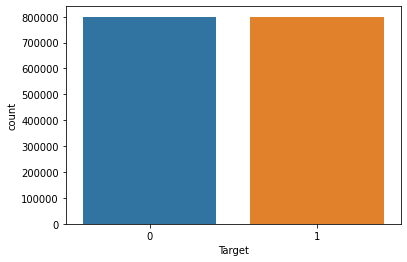

In [45]:
sns.countplot(x='Target', data=data)

In [46]:
data[data['Target'] == 0].head()

,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [47]:
data[data['Target'] == 1].head()

,Target,Text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


In [48]:
data = pd.concat([data[data['Target']==0].iloc[:10000], data[data['Target']==1].iloc[-10000:]])
data

,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


## Data Preprocessing

In [49]:
stopwords_ = set(stopwords.words('english'))
(", ").join(stopwords_)

"down, where, won, didn't, this, ma, while, him, just, re, shan't, being, she's, couldn't, isn, she, only, how, couldn, below, me, most, s, should, because, you, all, then, once, was, yours, won't, yourselves, further, it, are, my, over, by, ourselves, himself, o, as, into, d, after, shan, doing, has, haven't, theirs, weren, a, than, we, each, against, now, whom, such, doesn, ll, hadn't, shouldn't, with, had, on, needn't, which, hasn't, wouldn't, mightn't, those, yourself, out, of, is, that'll, off, there, if, having, needn, or, both, wouldn, other, ours, here, who, hers, y, does, about, your, no, above, haven, until, very, don, through, in, from, for, same, any, am, some, do, what, few, should've, herself, you'll, he, during, again, t, more, will, under, before, these, up, weren't, its, too, his, you'd, aren, and, myself, have, an, them, at, wasn, to, you're, hasn, why, can, mustn't, didn, mightn, her, don't, they, so, were, itself, been, i, isn't, doesn't, shouldn, ain, not, it's, wa

In [50]:
print("Original tweet: ")

print(data['Text'][0])

Original tweet: 
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D


In [51]:
def stopwords_removal(text):
    return " ".join([word for word in str(text).split() if word not in stopwords_])

tqdm.pandas()
data['Text'] = data['Text'].progress_apply(lambda text: stopwords_removal(text))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [52]:
print("After removal of stopwords: ")

print(data['Text'][0])

After removal of stopwords: 
@switchfoot http://twitpic.com/2y1zl - Awww, that's bummer. You shoulda got David Carr Third Day it. ;D


In [53]:
def cleaning_urls(text):
    text= re.sub('((www.[^\s]+)|(http[^\s]+))', ' ', text)
    text = text.lower()
    return text

data['Text'] = data['Text'].progress_apply(lambda text: cleaning_urls(text))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [54]:
print("After removing URLs: ")

print(data['Text'][0])

After removing URLs: 
@switchfoot   - awww, that's bummer. you shoulda got david carr third day it. ;d


In [55]:
def removing_usernames(text):
    text= re.sub('@[A-Za-z0–9]+', ' ', text)
    text = text.lower()
    return text

data['Text'] = data['Text'].progress_apply(lambda text: removing_usernames(text))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [56]:
print("After removing usernames: ")

print(data['Text'][0])

After removing usernames: 
    - awww, that's bummer. you shoulda got david carr third day it. ;d


In [57]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

data['Text'] =data['Text'].apply(lambda text: cleaning_numbers(text))

In [58]:
data['Text'] = data['Text'].progress_apply(tokenize.word_tokenize)
data['Text'].head()

  0%|          | 0/20000 [00:00<?, ?it/s]

0    [-, awww, ,, that, 's, bummer, ., you, shoulda...
1    [upset, ca, n't, update, facebook, texting, it...
2    [i, dived, many, times, ball, ., managed, save...
3              [whole, body, feels, itchy, like, fire]
4    [no, ,, behaving, all, ., i, 'm, mad, ., here,...
Name: Text, dtype: object

In [59]:
lem = nltk.stem.WordNetLemmatizer()
def lemmatizer(t):
    text = [lem.lemmatize(word) for word in t]
    return " ".join(t)
    
data['Text'] = data['Text'].apply(lambda text: lemmatizer(text))

In [60]:
punctuations= list(string.punctuation)

def cleaning_punctuations(text):
    return " ".join([word for word in str(text).split() if word not in punctuations])

tqdm.pandas()
data['Text'] = data['Text'].progress_apply(lambda text: cleaning_punctuations(text))

  0%|          | 0/20000 [00:00<?, ?it/s]

In [61]:
print("After removing punctuations: ")

print(data['Text'][0])

After removing punctuations: 
awww that 's bummer you shoulda got david carr third day it d


## Visualizing Words in Positive & Negative Tweet Texts

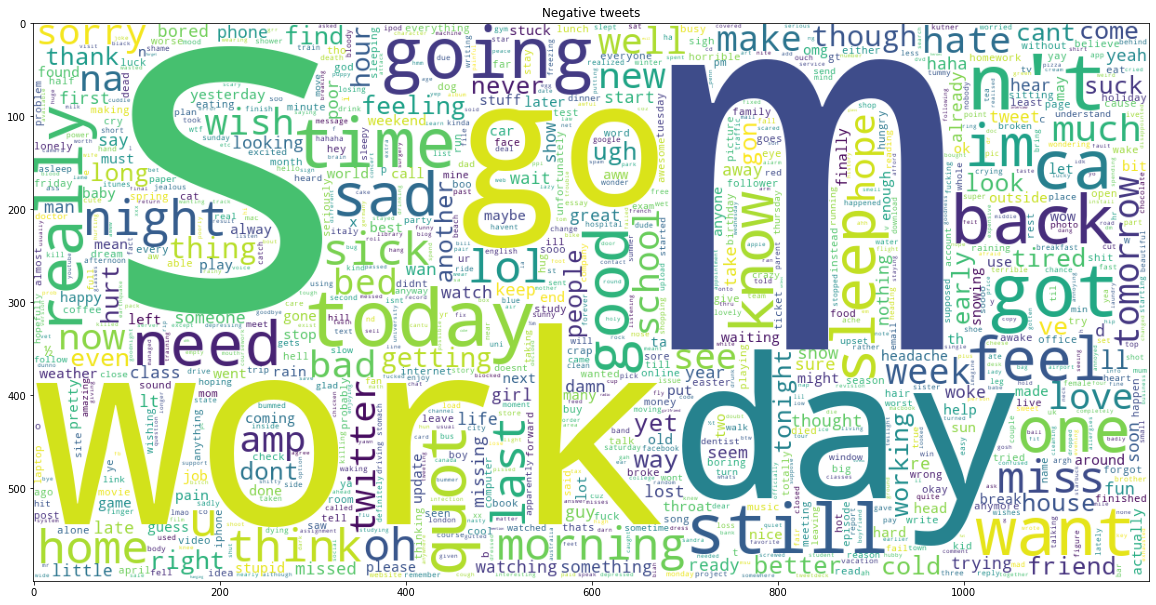

In [62]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, collocations=False).generate(" ".join(data[data['Target']==0]['Text']))
plt.figure(figsize = (20,20))
plt.title("Negative tweets")
plt.imshow(wc)

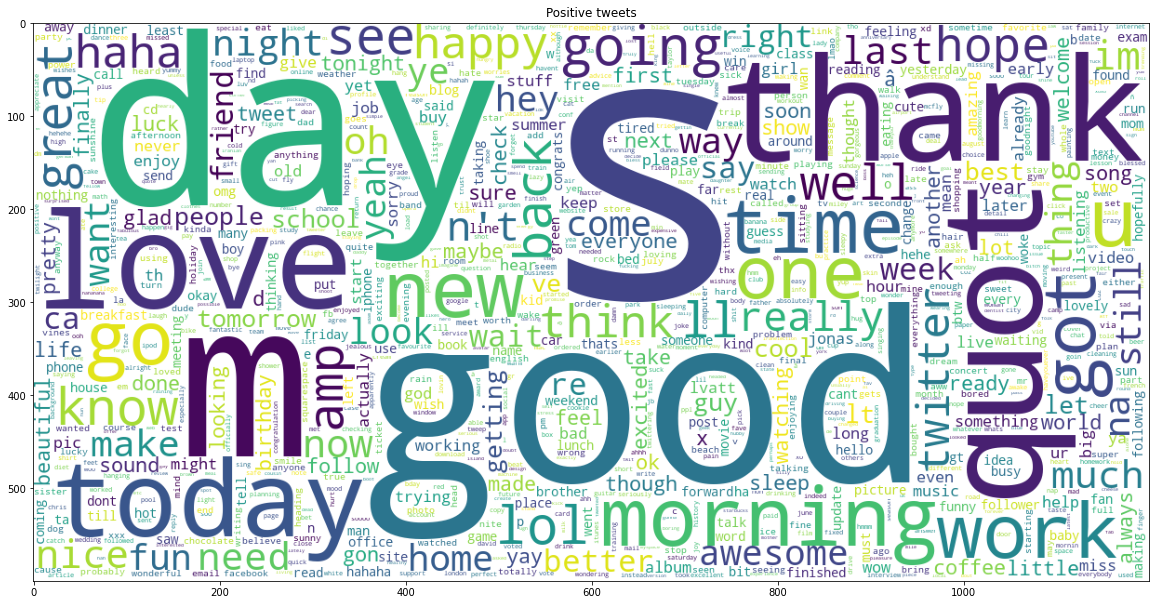

In [63]:
wc = WordCloud(background_color='white', max_words = 1000 , width = 1200 , height = 600, collocations=False).generate(" ".join(data[data['Target']==1]['Text']))
plt.figure(figsize = (20,20))
plt.title("Positive tweets")
plt.imshow(wc)

## Splitting Data Train & Test sets

In [64]:
X = data['Text']
y = data.Target

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1, random_state =5)

## TF-IDF Vectorization

In [66]:
vectoriser = TfidfVectorizer()
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  19175


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [67]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

## Model Building

In [91]:
def model_evaluate(model):
  y_pred = model.predict(X_test)
  print(classification_report(y_test, y_pred))

  # Confusion matrix
  cf_matrix = confusion_matrix(y_test, y_pred)
  categories = ['Negative','Positive']
  sns.heatmap(cf_matrix, annot = True, fmt = '', xticklabels = categories, yticklabels = categories)
  plt.xlabel("Predicted values")
  plt.ylabel("Actual values")
  plt.title ("Confusion Matrix")
  plt.show()

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       970
           1       0.75      0.76      0.75      1030

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



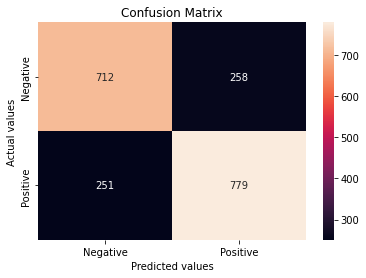

In [92]:
SVC = LinearSVC()
SVC.fit(X_train, y_train)
model_evaluate(SVC)

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       970
           1       0.75      0.76      0.76      1030

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000



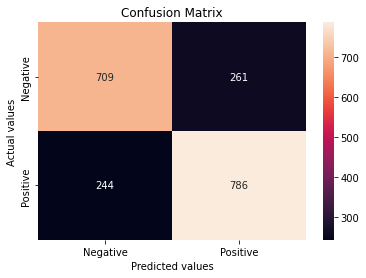

In [93]:
LR = LogisticRegression()
LR.fit(X_train, y_train)
model_evaluate(LR)
y_pred1 = LR.predict(X_test)

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       970
           1       0.77      0.76      0.76      1030

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



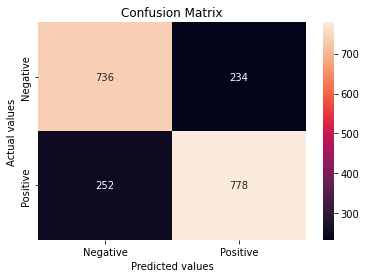

In [94]:
BNB= BernoulliNB()
BNB.fit(X_train, y_train)
model_evaluate(BNB)

              precision    recall  f1-score   support

           0       0.71      0.70      0.70       970
           1       0.72      0.74      0.73      1030

    accuracy                           0.72      2000
   macro avg       0.72      0.72      0.72      2000
weighted avg       0.72      0.72      0.72      2000



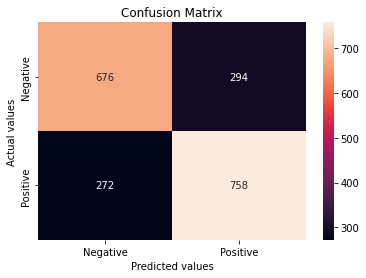

In [95]:
RF = RandomForestClassifier(n_estimators=200, max_depth=15)
RF.fit(X_train, y_train)
model_evaluate(RF)

**BernoulliNB has the highest f1-score of 0.76. Hence, we can say that BernoulliNB is the best model out of the 4.**